# Tecnologias de Processamento de dados - 2019/2020

## Phase III - Group 12


Student|Student ID|Contribution in hours
-|-|-
Beatriz Lima|49377|                      
David Almeida|54120|<center>8h</center>                  
João Castanheira|55052|                      
Pedro Cotovio|55053|

# 1. OLAP Queries

##  a. Previously defined queries

Check and revise the queries defined in Phase I. Ensure that the queries are meaningful for the processes at hand.

![Bus matrix](images/bus_matrix.png)

Demand queries (relative to the Bookings fact table):
 - The calendar period in which properties are available or not;
 - Locations where the properties are most available;
 - Correlation between host profile and demand for their listings;
 - The types of properties that are most sought after.
 
These queries were defined in Phase I and are still relevant for understanding the demand and the clients behaviour or preferences. We think that it might be interesting to pursue the analysis of the most popular locations in each time of the year.

Supply queries (relative to the Listings fact table):
 - Number of listings by parish or county, and their evolution over time;
 - Use the Review dimension to check in which parishes the listings with high review scores are located;
 - Check price evolution across differents locations;
 - Locations where hosts have listings in comparison to their listed residence (“Are hosts residents in foreign countries?”, “Are they investors from richer countries?”);
 - Analyse the evolution over time and across locations, of types of properties using the Property dimension, providing an overview on what the platform can supply.
 
 ###### Comment on relevance of these queries... Including CRM


## b. For each query type identify dimensions, attributes and measures for each one

- **Query 1**) hottest months/dates and most popular locations.
This analysis involves the date and location dimensions, and the bookings fact table. We will try different grains of detail, going from weeks to months and seasons, etc. The same goes for the location, where the hierarchy of parish and county will be explored through roll up or down operations. We will also try to establish an association with the KPI Monthly Profit Per Property.


- **Query 2**) locations where hosts have listings in comparison to their listed residence.
This query looks at the ownership of Airbnb-listed properties by extracting information about listings' locations and their respective hosts' locations. It will make use of two dimensions, Location and Host, associated with the Listings fact table. In this way, we can understand how ownership is distributed, that is, if listings are hosted by locals, or by foreigners that have invested in properties abroad.


- **Query 3**) Query castas 


- **Query 4**) CRM --- define query

## c. SQL queries 
Write the SQL queries and execute them. Make sure the results are understandable

In [18]:
#1. Libraries
import psycopg2 as pg
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
import os
from db_connection import dbconnection as db

### Query 1 -  hottest months/dates and most popular locations 

In [88]:
query1= """
SELECT d.year, d.season, l.street, l.parish, l.coastal_area, count(b.property_id) as nr_bookings,  b.price_per_night, (count(*)*b.price_per_night) as gain
FROM date d, booking b, location l
WHERE b.date_id = d.date_id
AND b.location_id = l.location_id
GROUP BY d.year, d.season, l.street, l.parish, l.coastal_area, b.price_per_night
ORDER BY gain DESC
"""

In [89]:
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
q1_df = sqlio.read_sql_query(query1, conn)

In [90]:
q1_df.head(10)

,year,season,street,parish,coastal_area,nr_bookings,price_per_night,gain
0,2021,Winter,RUA CASTANHEIROS,Quinta da Marinha,Coastal Area,15,8000,120000
1,2020,Summer,AVENIDA ATLÂNTICO,Pinhal da Nazaré,Coastal Area,49,628,30772
2,2020,Summer,1ª RUA DA QUINTINHA,Lisboa,Coastal Area,60,400,24000
3,2020,Spring,TRAVESSA DO PINHEIRO,Lisboa,Coastal Area,16,1300,20800
4,2020,Summer,RUA CASTANHEIROS,Quinta da Marinha,Coastal Area,92,184,16928
5,2020,Summer,TRAVESSA DO PINHEIRO,Lisboa,Coastal Area,15,1100,16500
6,2020,Summer,TRAVESSA DO PINHEIRO,Lisboa,Coastal Area,12,1300,15600
7,2020,Spring,TRAVESSA DOS INGLESINHOS,Lisboa,Coastal Area,58,265,15370
8,2020,Summer,ESTRADA LEXIM CASA SHANTI PENEDO,Igreja Nova,Coastal Area,92,150,13800
9,2020,Autumn,ESTRADA LEXIM CASA SHANTI PENEDO,Igreja Nova,Coastal Area,91,150,13650


We could conclude that:
- Airbnb is able to produce revenue in all seasons of the year, having at least one most profitable kind of booking per season.
- most of the profitable bookings are made in the Summer.
- regardless of the season, Airbnb clients prefer properties in the coastal area.
- some places have fewer bookings per season (for example, Quinta da Marinha) but since the price per night is so high, they are very profitable. 
- Travessa do Pinheiro is a very popular street, being very profitable even though the price per night can be as low as 12€

### Query 2 - property ownership characteristics

In [12]:
query2 = """
DROP VIEW IF EXISTS query2;

CREATE VIEW query2 AS
SELECT
    location.street, location.parish, location.county,
    host.host_country, host.host_continent, host.host_country_gdp, host.membership_duration,
    count(*)
FROM 
	listings,
	location,
	host
WHERE
	location.street LIKE '%' AND
	listings.location_id = location.location_id AND
	listings.host_id = host.host_id
GROUP BY
	location.street, location.parish, location.county,
    host.host_country, host.host_continent, host.membership_duration, host.host_country_gdp
ORDER BY street ASC, count DESC;

SELECT * FROM query2
"""

In [13]:
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
q2_df = sqlio.read_sql_query(query2, conn)
conn = None

In [14]:
q2_df.to_csv('q2.csv')
display(q2_df)

,street,parish,county,host_country,host_continent,host_country_gdp,membership_duration,count
0,1ª CANADA RUA DO CARDAL,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 5 years,1
1,1ª RUA 18,Barcarena,Oeiras,Portugal,Europe,20k - 35k,Member for more than 2 years,1
2,1ª RUA 5 DE OUTUBRO,Ericeira,Mafra,Portugal,Europe,20k - 35k,Member for more than 5 years,2
3,1ª RUA 5 DE OUTUBRO,Ericeira,Mafra,Germany,Europe,35k - 50k,Member for more than 5 years,1
4,1ª RUA 61,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 5 years,1
...,...,...,...,...,...,...,...,...
4648,ZONA ESCOLAS GERAIS,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 5 years,3
4649,ZONA ESCOLAS GERAIS,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 2 years,2
4650,ZONA ESCOLAS GERAIS,Lisboa,Lisboa,Portugal,Europe,20k - 35k,Member for more than 1 year,1
4651,ZONA SÍTIO DO CASTELO,Cascais,Cascais,Portugal,Europe,20k - 35k,Member for more than 5 years,2


In [15]:
idx = input("Choose property location attribute to cross:")
col = input("Choose host residence attribute to cross:")

q2_pivot = pd.pivot_table(q2_df, values = 'count', index = idx, columns = col, aggfunc = sum, margins = True)
display(q2_pivot)

Choose property location attribute to cross:parish
Choose host residence attribute to cross:host_country


host_country,Angola,Australia,Austria,Belgium,Brazil,Canada,China,Denmark,Finland,France,...,Spain,Sri Lanka,Sweden,Switzerland,Turkey,United Arab Emirates,United Kingdom,United States,Vietnam,All
parish,,,,,,,,,,,,,,,,,,,,,
A dos Cunhados,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
Abelheira,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
Abrunheira,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
Achada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
Adão Lobo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vimeiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Várzea de Sintra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
Zambujal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


The motivation behind this query is the business interest in profiling and targetting. Naturally, for a business to expand and succeed, it must identify its target audience and its goal market, so as to intervene in this space and promote its role there. In the business intelligence side, how is it possible to accurately identify who is using a service? This is achieved by analysing customer/client data.

For the Airbnb model, there are two types of targets: customers, a.k.a. tourists, which seek to use Airbnb's platform to book a stay or an experience somewhere, and hosts, which use Airbnb's platform to advertise their properties and services to a broader audience. Both are essential, of course, for this business model to work: they work as demand and supply, respectively, and must coexist in a balanced fashion. Airbnb profits from both: more clients lead to more bookings, which generate direct revenue from the fee Airbnb takes from every listing, and more hosts expands the options Airbnb offers, increasing the likelihood clients will have something to their taste, and increasing the number of revenue sources.

This query seeks to profile hosts in a manner that understands their geo-economical context. This is an important insight to obtain. Customer data would be even more precious for this type of analysis, however, such data is not at our disposal, and as such, we opted for this approach to work as a sort of proof-of-concept.

For this, we extract information about the host's location of residence and cross it with their owned properties' information, in order to understand if there are interesting patterns in property ownership according to host characteristics. The pivot table format makes the interpretation of this data much clearer by crossing fields of interest.

If implemented in a more user-friendly manner, attribute selection for the pivot table would have a more intuitive interface. With the _.csv_ file produced, it's possible to create a data visualisation dashboard that eases interpretation and analysis. For this, we used the software Power BI.

Via Wikidata's SPARQL Query Tool, it's possible to obtain many different kinds of data. Geographical coordinates for Portuguese parishes were extracted from the database using an appropriate query and downloaded as a _.csv_ file. Both _.csv_ were uploaded to Power BI, related by their attribute "Parish", and, in this way, the number of properties in each geographical location can be associated with their place on a map.

Other options, such as importing additional geographical data (for counties, for example, and other countries, if the dataset encompassed more than one country), would also result in interesting visualisations to analyse with distinct levels of granularity.

Below, we can see the resulting dashboard. Each circle is proportional to the number of properties in the corresponding location, and it's sliced in a pie chart to denote which countries the hosts are residents of. Other host characteristics could be selected to define the pie chart.

<img src="DashboardQ2.png" alt="Power BI Query 2 Dashboard" width="1000"/>

### Query 3 - Analyse the evolution over time and across locations, of types of properties using the Property dimension, providing an overview on what the platform can supply


In [44]:
query3 = """
    select d.year, lo.parish, p.property_type_category, count(*) from listings l
    inner join property p on p.property_id = l.property_id
    inner join date d on d.date_id = l.date_id
    inner join location lo on lo.location_id = l.location_id
    group by d.year, lo.parish, p.property_type_category
    order by d.year, lo.parish, p.property_type_category asc
"""

In [46]:
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
q3_df = sqlio.read_sql_query(query3, conn)
conn = None
q3_df.shape

(727, 4)

In [47]:
q3_df.head()

,year,parish,property_type_category,count
0,1967,Queluz,Apartment,3
1,1970,Lisboa,Apartment,1
2,1985,Lisboa,Apartment,2
3,1986,Praia Grande,House,1
4,1998,Samarra,House,3


In [50]:
df_merge_q3 = pd.merge(q3_df,df_cp, how='inner', on='parish')
df_merge_q3 = df_merge_q3.drop_duplicates(['year','parish','property_type_category'])[['year','parish','count','property_type_category','num_cod_postal','ext_cod_postal']]
df_merge_q3['cp'] = df_merge_q3['num_cod_postal'].astype(str) +'-'+ df_merge_q4['ext_cod_postal'].astype(str)
df_merge_q3 = df_merge_q3[['year','parish','count','property_type_category','cp']]
df_merge_q3.sort_values(['year','parish'],ascending = True)

,year,parish,count,property_type_category,cp
0,1967,Queluz,3,Apartment,2745-377
3060,1970,Lisboa,1,Apartment,1700-921
14533,1985,Lisboa,2,Apartment,1700-921
473453,1986,Praia Grande,1,House,8400-273
473473,1998,Samarra,3,House,2705-735
...,...,...,...,...,...
515185,2019,Terrugem,1,House,2770-184
608032,2019,Tires,1,Apartment,2785-244
567134,2019,Tojeira,1,House,4860-212
601863,2019,Várzea de Sintra,1,House,2710-664


In [51]:
df_merge_q3.to_csv('query3.csv')

### Query 4 - Costumer relationship management

**Pre-Process** In order to facilitate queries we will redo the Reviews Dimension using numerical variables.

In [20]:
# Retreive Current Reviews
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
table_name = 'review'
df_reviews = db.query_table(conn, table_name)
df_reviews.head()

,review_id,rating,accuracy,cleanliness,communication,location
0,1,Very good,Description is not accurate,Clean,Good communication,Good location
1,2,Average,Description is not accurate,Clean,Good communication,Good location
2,3,Good,Description is not accurate,Clean,Good communication,Good location
3,4,Bellow average,Description is not accurate,Clean,Good communication,Good location
4,5,Average,Description is not accurate,Clean,Bad communication,Good location


In [23]:
# Map Categorical Reviews to Numerical Values

mapping = {
    'rating': {
        'Bellow average': 0,
        'Average': 1,
        'Good': 2,
        'Very good': 3,
        'Excelent': 4
    },
    'accuracy': {
        'Description is not accurate': 0,
        'Accurate description': 1
    },
    'cleanliness': {
        'Not clean': 0,
         'Clean': 1
    },
    'communication': {
        'Bad communication': 0,
        'Good communication': 1
    },
    'location': {
        'Bad location': 0,
        'Good location': 1
    }
}
try:
    df_reviews.replace(mapping, inplace=True)
except TypeError:
    pass

# Add Sum Column
df_reviews['score'] = df_reviews.sum(axis=1)
df_reviews.head()

,review_id,rating,accuracy,cleanliness,communication,location,score
0,1,3,0,1,1,1,7
1,2,1,0,1,1,1,6
2,3,2,0,1,1,1,8
3,4,0,0,1,1,1,7
4,5,1,0,1,0,1,8


**Inject database**

In [ ]:
# Insert Table
insert_sql = """
DROP TABLE IF EXISTS CS; 
CREATE TABLE CS (
REVIEW_ID SERIAL PRIMARY KEY NOT NULL,
RATING INT NOT NULL, 
ACCURACY INT NOT NULL,
CLEANLINESS INT NOT NULL,
COMMUNICATION INT NOT NULL,
LOCATION INT NOT NULL,
SCORE INT NOT NULL
);
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
db.run_sql_command(insert_sql, conn)

# Insert DATA
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
db.insert_data(df_reviews, 'CS', conn)

# Insert Constraints
insert_c = """
ALTER TABLE listings
DROP CONSTRAINT IF EXISTS constraint_fkey;
ALTER TABLE listings 
ADD CONSTRAINT cn FOREIGN KEY (review_id) REFERENCES CS (review_id);
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(insert_c, conn)
if success is True: print('Done')

#### KPI's

A KPI is a measurable value that demonstrates how effectively a company is achieving key business objectives. We decided to create some KPIs in order to better evaluate the companies' interests through our queries.

The metrics are normalized, meaning that 100% represents the best case scenario where all the properties are maximizing their potential.

* Customer Satisfaction, where in a best-case scenario all properties would have maximum ratings.
* Monthly Profit Per Property, where in a best-case scenario all properties would be as profitable as the most profitable property.
* Company’s Performance is a combination of the previous two and shows how much of their potential the company is currently tapping into.

In [27]:
# Create Metrics View

# Normalized Customer Satisfaction Metric
norm_cs_sql = """
CREATE OR REPLACE FUNCTION normalized_cs()
RETURNS TABLE
            (
                id INT,
                normalized_cs NUMERIC
            )
AS $$
BEGIN
RETURN QUERY
    SELECT
    x.id, 1.00*(sample-min_metric)/range_metric
    FROM
        (
        SELECT
               cs.id,
               metric AS sample,
               MIN(metric) OVER () AS min_metric,
               MAX(metric) OVER () - MIN(metric) OVER () AS range_metric
        FROM
             (SELECT property.property_id as id, cs.score as metric
                FROM cs
                    INNER JOIN listings
                        ON cs.review_id = listings.review_id
                    INNER JOIN property
                        ON listings.property_id = property.property_id
                ) as cs
        ) x ;

END;
$$ LANGUAGE plpgsql;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(norm_cs_sql, conn)

# Normalized Profit Metric
norm_profit_sql = """
CREATE OR REPLACE FUNCTION normalized_profit()
RETURNS TABLE
            (
                id INT,
                normalized_profit NUMERIC
            )
AS $$
BEGIN
RETURN QUERY
    SELECT
    x.id, 1.00*(sample-min_metric)/range_metric as normalized_profit
    FROM
        (
        SELECT
               cs.id,
               metric AS sample,
               MIN(metric) OVER () AS min_metric,
               MAX(metric) OVER () - MIN(metric) OVER () AS range_metric
        FROM
             (SELECT p.id, AVG(rented_days * avg_price_per_night)/30 as metric
                FROM (
                     SELECT CAST(count(*) as NUMERIC) as rented_days, booking.property_id as id, AVG(booking.price_per_night) as avg_price_per_night
                     FROM booking
                              INNER JOIN date
                                         ON booking.date_id = date.date_id
                     GROUP BY property_id, month, year
                     ) as p
                GROUP BY p.id
             ) as cs
        ) x ;

END;
$$ LANGUAGE plpgsql;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(norm_profit_sql, conn)

In [31]:
# Create View

metrics_sql = """
CREATE VIEW IF NOT EXISTS metrics AS
    SELECT normalized_cs.id, avg(normalized_cs) as cs, avg(normalized_profit) as profit, avg(normalized_cs + normalized_profit) as score
    FROM normalized_cs(), normalized_profit()
    WHERE normalized_cs.id = normalized_profit.id
    GROUP BY normalized_cs.id;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(metrics_sql, conn)

# Test
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
test = db.query_table(conn, 'metrics')
test.head()

,id,cs,profit,score
0,1,0.053198,0.147830,0.201028
1,2,0.066290,0.151472,0.217762
2,3,0.054701,0.789456,0.844157
3,4,0.064919,0.065337,0.130256
4,5,0.034074,0.068080,0.102154


In [32]:
# get KPI's

conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
cs = db.query_kpis(conn, method='cs')
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
profit = db.query_kpis(conn, method='profit')
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
score = db.query_kpis(conn, method='score')

# Print
print('Customer Satisfaction {}%'.format(cs))
print('Monthly Profit Per Property {}%'.format(profit))
print("Company's Performance {}%".format(score))

Customer Satisfaction 6.49%
Monthly Profit Per Property 12.18%
Company's Performance 18.67%


**TOP 10 Ranking Properties according to KPIs (reviews and profitability)**

In [35]:
# Function to get top N ranking properties
topn_sql = """
CREATE OR REPLACE FUNCTION topN(N int)
RETURNS TABLE
            (
                id INT,
                score NUMERIC,
                property_type VARCHAR,
                room_type VARCHAR,
                accommodates VARCHAR,
                bathrooms VARCHAR,
                bedrooms VARCHAR,
                beds VARCHAR,
                bed_type VARCHAR
            )
AS $$
BEGIN
RETURN QUERY
    SELECT metrics.id, metrics.score/2, property.property_type,
           property.room_type, property.accommodates, property.bathrooms, property.bedrooms,
           property.beds, property.bed_type
    FROM metrics
    INNER JOIN property
        ON metrics.id = property.property_id
    ORDER BY metrics.score desc
    LIMIT N;
END;
$$ LANGUAGE plpgsql;
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(topn_sql, conn)

# Retrieve Properties
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
top10 = db.query_table(conn, 'topN(10)')
top10

,id,score,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,128,0.500000,House,Entire home/apt,Up to 4 guests,3 bathrooms,T2,4+ beds,Real Bed
1,3,0.422078,Apartment,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
2,92,0.330318,Villa,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
3,51,0.285870,Apartment,Entire home/apt,Up to 7 guests or more,3 bathrooms,T3,4+ beds,Real Bed
4,147,0.222839,Villa,Entire home/apt,Up to 7 guests or more,3 bathrooms,T4+,4+ beds,Real Bed
5,23,0.218349,Apartment,Entire home/apt,Up to 7 guests or more,2 bathrooms,T4+,4+ beds,Real Bed
6,13,0.206479,Apartment,Entire home/apt,Up to 7 guests or more,3 bathrooms,T4+,4+ beds,Real Bed
7,126,0.204479,House,Entire home/apt,Up to 7 guests or more,2 bathrooms,T4+,4+ beds,Real Bed
8,48,0.178228,House,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
9,112,0.173954,Apartment,Entire home/apt,Up to 7 guests or more,1 bathroom,T4+,4+ beds,Real Bed


Properties in the top 10 are mostly big properties that accommodate many guests, some interesting characteristics are:

* All are private properties
* Accommodate mostly 7 or more guests
* Have 4+ Beds
* All beds are real beds and not couches
* Scores are at maximum 50%, so properties are not near their full potential

# 2. Bottlenecks

##  a. / b. Most important bottlenecks and performance analysis +  Plan for improving performance
Identify the most important bottlenecks and execute performance analysis

### Query 1

### Query 2

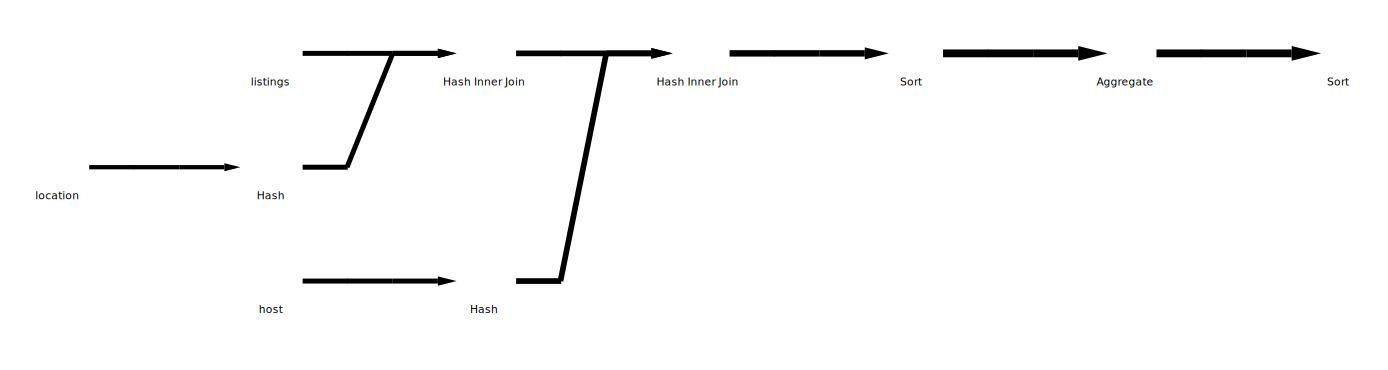

In [36]:
from IPython.display import SVG
SVG(filename='q2_plan1.svg')

This query already works with significant speed. However, a materialized view is a candidate to reduce computation time for this query. In this way, every time the query was run, only the view table would need to be consulted, and all aggregations and sortings would have been done already. But a materialized view benefits most the cases where queries are run often and updates aren't constant, because in this way, the view table available is already pre-computed with all the necessary data.

Overall, this query wouldn't be one to run very frequently. After all, property ownership trends and patterns are expected to change over many years, and any effort by Airbnb to influence this would only be possible to analyse after a significant amount of time. As such, its computational efficiency isn't an urgent necessity for the business process.

Implementing a materialized view (given that the appserver's PostgreSQL version does not support this, a new equivalent data table was created), the querying of data becomes a simple subsetting of the table columns and the query is reduced to a quick sequential scan.

### Query 3

### Query 4

Let us analyse each component of the query:

**Normalized Customer Satisfaction**
![image.png](attachment:28cd91a5-f993-4c8f-b244-8c93d022f799.png)

The R system is doing 3 full scans: 

* The first is optional since we are merging tables `listings` and `property` on `property_id`. This column as an automatic hash index, but since these two tables have a one-one relashionship, it's a full scan is more efficient.
* The second full scan is to load the `cs` table, since we want to retrieve all the rows from this table, this is the more efficient approach
* The last full scan is also the must efficient approach since we are merging `listings` to `cs`, where all values of cs are necessary.

All these scans are fully optimized since we need to load completely all these tables. Then R uses hashing to join the tables. This query is optimized.

**Normalized Profit**
![image.png](attachment:f75c9ee1-1080-43db-82c9-6ee032721d1d.png)

This is also optimized the only full scans that are made, are in tables that need to be completely load to memory. The aggregations are also necessary and cannot be avoided.

**Metrics View**
![image.png](attachment:f4fc9c48-4b56-46a7-9669-dc764e414b23.png)

This is a simple query to collect the previous results and build a materialized view. Difficult to optimize since its calling functions, this way is not possible to set an index for the merge, and so two sorts are a merge join are necessary.

**TOP10 Properties**
![image.png](attachment:bc21fcbd-cd97-4ca4-8ab6-bbdbf57dfb32.png)

This query is definitely not a bottleneck, but it can be slightly optimized by having an index on the score column, to remove the need for sorting.

In conclusion, there were no bottlenecks and all queries run smoothly, since we can run this notebook almost instantly. The only modification that could improve performance, would be to score review information as numeric variables, but that could prejudice further analyses, like data mining.

## c. Verify that the proposed modifications have better performance

### Query 1

### Query 2

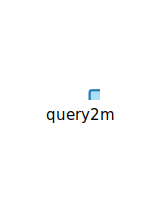

In [41]:
SVG(filename='q2_plan2.svg')

### Query 3

### Query 4

In [37]:
index_sql = """
CREATE INDEX score ON metrics(score desc);
"""
conn = pg.connect(host = db.server_host,database = db.dbname, user = db.dbusername,password = db.dbpassword,sslmode=db.sslmode)
success = db.run_sql_command(topn_sql, conn)
if success is True: print('Index Created')

Index Created


In [39]:
![image.png](attachment:626125ca-0d78-4806-a915-716f39cf65db.png)

/bin/sh: -c: line 0: syntax error near unexpected token `attachment:626125ca-0d78-4806-a915-716f39cf65db.png'
/bin/sh: -c: line 0: `[image.png](attachment:626125ca-0d78-4806-a915-716f39cf65db.png)'


### d. Discussion

With the full use of the data warehouse what are the expectation for its growth in 1, 5 and 10 years. Identify what approaches would be used to address such an increase in data

# 3. Critical assessment

###  a. Phases comparison
For each of the 3 phases of the project discuss what went right, wrong and what would you do to make it better?

In Phase II, each ETL process could have been optimised to perform better, as well as have cleaner code. For example, some ETL pipelines for certain dimensions were designed in such a way as to allow for constant reuse of the code without redundant calculations (it works for either first insert of the data/dimension construction, or for any subsequent data insertions), whereas other pipelines were divided into dimension construction/first data insertion + subsequent data insertions.

Overall, the chosen dataset has its limitations in the ways we can model the data. This is mainly due to the fact that it is a product of web scraping and, as such, important information for business intelligence is unattainable. Certain initial plans had to be changed. However, it also allowed us to explore particular cases of data warehouse design and dimension modelling, such as the factless fact table Bookings.

### b. Grade proposal
For each phase propose a grade (1-20). Justify your grade.

